In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 440kB 5.3MB/s 
     |████████████████████████████████| 235kB 36.7MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 


In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [ ]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [ ]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


In [ ]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.9447 - acc: 0.1000 - val_loss: 1.8978 - val_acc: 0.2820
Epoch 2/200
1/1 - 0s - loss: 1.8870 - acc: 0.2857 - val_loss: 1.8421 - val_acc: 0.3020
Epoch 3/200
1/1 - 0s - loss: 1.8324 - acc: 0.3000 - val_loss: 1.7814 - val_acc: 0.3020
Epoch 4/200
1/1 - 0s - loss: 1.7605 - acc: 0.3071 - val_loss: 1.7189 - val_acc: 0.3020
Epoch 5/200
1/1 - 0s - loss: 1.6738 - acc: 0.3071 - val_loss: 1.6527 - val_acc: 0.3020
Epoch 6/200
1/1 - 0s - loss: 1.5918 - acc: 0.3214 - val_loss: 1.5856 - val_acc: 0.3120
Epoch 7/200
1/1 - 0s - loss: 1.4868 - acc: 0.3571 - val_loss: 1.5183 - val_acc: 0.3380
Epoch 8/200
1/1 - 0s - loss: 1.4172 - acc: 0.3857 - val_loss: 1.4461 - val_acc: 0.3980
Epoch 9/200
1/1 - 0s - loss: 1.3204 - acc: 0.4714 - val_loss: 1.3738 - val_acc: 0.4820
Epoch 10/200
1/1 - 0s - loss: 1.2038 - acc: 0.5571 - val_loss: 1.3040 - val_acc: 0.5380
Epoch 11/200
1/1 - 0s - loss: 1.1652 - acc: 0.5500 - val_loss: 1.2363 - val_acc: 0.5980
Epoch 12/200
1/1 - 0s - loss: 1.0758 - ac

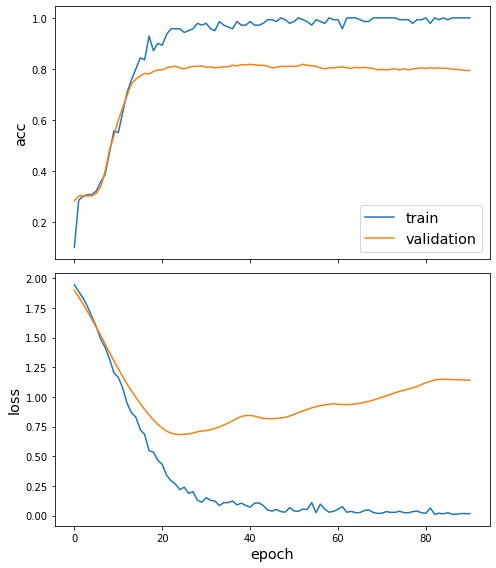

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 54ms/step - loss: 0.8229 - acc: 0.7853

Test Set Metrics:
	loss: 0.8229
	acc: 0.7853


In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [ ]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [ ]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Probabilistic_Methods,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [ ]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 16)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [ ]:
X = emb.squeeze(0)
X.shape

(2708, 16)

In [ ]:
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

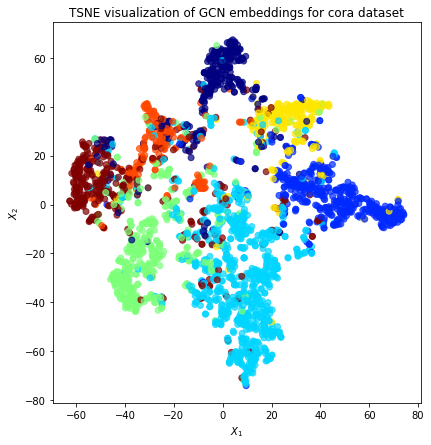

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)